In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class AetasStellae():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1):
        
        '''
        teff: [float] Teff of star
        feh: [float] metallicity [Fe/H] of star
        cnalpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        phot: [array] observed [BP,RP,J,H,K] photometry
        phot_err: [array] observed [BP,RP,J,H,K] photometry error
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff # temperature
        self.salfeh = self.salariscorrectedfeh(feh,cnalpha) # Metallicity
        self.phot = obsphot # photometry
        self.phot_err = obsphot_err # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def salariscorrectedfeh(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            salfeh: Salaris corrected metallicity
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
                
        if np.isfinite(feh)==False:
            feh = 0.0
        
        # Calculate enhancement factor and corrected metallicity
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav    
        
    def teff2appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def fit(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff2appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(14.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff2appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
    def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
        Inputs:
        ------
            best_fit_params: [array]
            lit_age: [float] optional known literature age in Gyr
            filename: [str] optional filename of plot if saving
        '''
        
        # initialize arrays
        ages = np.arange(0,15,0.25)
        theos = 999999.0*np.ones((len(ages),5))
        theos_noext = 999999.0*np.ones((len(ages),5))
    
        # calculate theoretical age for given ages
        for j in range(len(ages)):
            theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
            theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for i in range(5):
            ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
            ax[i].plot(theos[:,i],ages)
            
            ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
            ax[i].plot(theos_noext[:,i],ages)
            
            ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age!=None:
                ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
            ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
            ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
            ax[i].set_ylim(bottom=0.01)
            
            ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
            ax[i].set_xlabel(r'Magnitude')
            
        ax[0].legend()

        ax[0].set_ylabel('Age')
        
        if star_name!=None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
                                                                          best_fit_params[1],self.distance))
        
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
                                                                      self.distance))
    
        if filename!=None:
            plt.savefig(filename,bbox_inches='tight')
        plt.show()
        
    def extinct(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        lgteff = np.log10(self.teff)

        ebpk_k = ((self.cardelli_alav(self.leff['G_BPmag'])-self.cardelli_alav(self.leff['Ksmag']))/
              self.cardelli_alav(self.leff['Ksmag']))
        erpk_k = ((self.cardelli_alav(self.leff['G_RPmag'])-self.cardelli_alav(self.leff['Ksmag']))/
              self.cardelli_alav(self.leff['Ksmag']))
        ejk_k = ((self.cardelli_alav(self.leff['Jmag'])-self.cardelli_alav(self.leff['Ksmag']))/
             self.cardelli_alav(self.leff['Ksmag']))
        ehk_k = ((self.cardelli_alav(self.leff['Hmag'])-self.cardelli_alav(self.leff['Ksmag']))/
             self.cardelli_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])

        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:

            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])

            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0
#                 return 999999.0

            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]

            ### use a spline to get the intrinsic color and calculate the reddening
            calc_reds = 999999.*np.ones(4)
            for i in range(4):
                color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteff)

            ### calculate the Ak value
            calc_ak = np.median(np.divide(calc_reds,ccm))

            if verbose:
                print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                print(ccm)
                print(np.divide(calc_reds,ccm))
                print('Calc Ak: ',calc_ak)
            self.ak = calc_ak
#             return calc_ak

        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

            ### Pick out single isochrones

            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])

            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0   
#                 return 999999.0
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0
#                 return 999999.0

            ### sort so temp is always increasing

            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]

            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]

            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_reds = 999999.*np.ones(4)
            for i in range(4):
                color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[color_spl_lo(lgteff),color_spl_hi(lgteff)],1)))
                if verbose:
                    print(age_spl_interp)
                    print(lgteff)
                    print(age_spl_interp(lgteff))
                    print(self.phot[i]-self.phot[4])
                calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

            ### calculate the Ak value
            calc_ak = np.median(np.divide(calc_reds,ccm))

            if verbose:
                print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                print('CCM: ',ccm)
                print('Ak each band',np.divide(calc_reds,ccm))
                print('Calc Ak: ',calc_ak)
                
            self.ak = calc_ak
#             return calc_ak

    def teff2appmags2(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags

# Cardelli Extinction

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)
ebv_ak = (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC Isochrones

In [ ]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [ ]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
gcs = Table(gcs[np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-9999.0)&(np.isfinite(gcs['FE_H'])==True))])
gcs = gcs[np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                   (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M15')|
                   (gcs['CLUSTER']=='M19')|(gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|
                   (gcs['CLUSTER']=='M3')|(gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|
                   (gcs['CLUSTER']=='M53')|(gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|
                   (gcs['CLUSTER']=='M68')|(gcs['CLUSTER']=='M71')|(gcs['CLUSTER']=='M79')|
                   (gcs['CLUSTER']=='M92')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                   (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                   (gcs['CLUSTER']=='NGC5053')|(gcs['CLUSTER']=='NGC5466')|(gcs['CLUSTER']=='NGC6304')|
                   (gcs['CLUSTER']=='NGC6388')|(gcs['CLUSTER']=='NGC6752')|(gcs['CLUSTER']=='NGC6760'))]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, gcs_ind, dr17_ind = np.intersect1d(gcs['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

gcsdr17 = dr17[dr17_ind]
gcs = gcs[gcs_ind]

gcs_clus = np.unique(gcs['CLUSTER'])

In [ ]:
med_apo_feh = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcsdr17['FE_H']>-100.))
    med_apo_feh = np.append(med_apo_feh,np.nanmedian(gcsdr17['FE_H'][clus]))
#     print('{}: {:.3f}'.format(gcs_clus[i],np.nanmedian(gcsdr17['FE_H'][clus])))
    
harris_dist = np.array([4.5,4.4,6.3,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,
                        9.6,8.9,4.9,8.6,17.4,16.0,5.9,9.9,4.0,7.4])*1000
harris_feh = np.array([-0.72,-1.56,-1.02,-1.37,-1.53,-2.37,-1.74,-1.65,-1.70,-1.50,-1.16,-1.29,-2.10,-1.49,-1.94,
                       -2.23,-0.78,-1.60,-2.31,-1.18,-1.14,-1.32,-1.59,-1.26,-2.27,-1.98,-0.45,-0.55,-1.54,-0.40])
harris_ext = np.array([0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.06,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,
                       0.02,0.02,0.22,0.03,0.24,0.05,0.01,0.00,0.54,0.37,0.04,0.77])
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris_dist[i]
#     print(clus)

print('Harris-APOGEE:',np.median(harris_feh-med_apo_feh))
print('VandenBerg-APOGEE:',np.median(vanden_feh-med_apo_feh))
print('Overall:',np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

shiftfeh = 999999*np.ones(len(gcsdr17))
for i in range(len(gcsdr17)):
    clus = np.where(gcs['CLUSTER']==gcs['CLUSTER'][i])
    if np.isfinite(gcsdr17['FE_H'][i])==False:
        shiftfeh[i] = (np.median(gcsdr17['FE_H'][clus])+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
    else:
        shiftfeh[i] = (gcsdr17['FE_H'][i]+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
        
plt.plot(shiftfeh)

In [ ]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
        
    if np.isfinite(feh)==False:
        feh = 0.0
    
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

In [ ]:
all_sal_feh = np.array([])
for i in range(len(gcsdr17)):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
#     all_sal_feh = np.append(all_sal_feh,salaris(gcsdr17['FE_H'][i],cnalpha))
    all_sal_feh = np.append(all_sal_feh,salaris(shiftfeh[i],cnalpha))
    
plt.figure(figsize=[10,10])
plt.plot(all_sal_feh)
plt.axhline(-0.005,c='k')

In [ ]:
plt.hist(all_sal_feh[np.where(all_sal_feh>-0.005)])

# Gaia Errors

In [ ]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [ ]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

In [ ]:
bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [ ]:
gcsdr17.columns

<font size='15'>
    <b>
        Generate APOGEE Synthetic Data
    </b>
</font>

Number of Clusters 30
TEFF


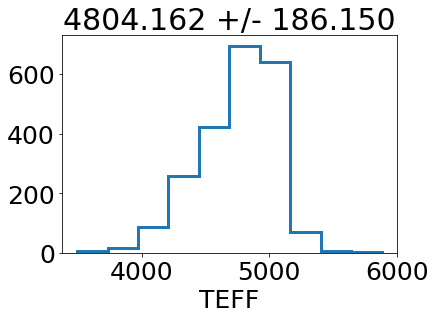

TEFF: min 3492.200 max 5881.855 sterr 14.320
----------
ABUNDANCES


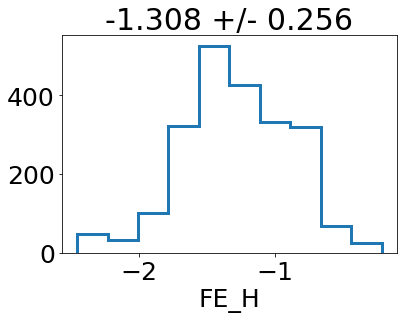

FE_H: min -2.459 max -0.212 sterr 0.013
----------


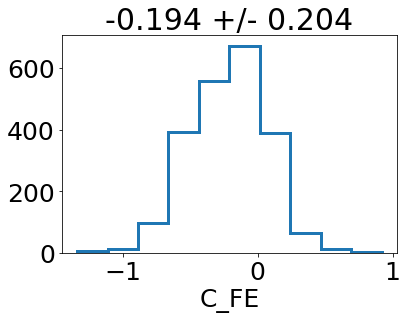

C_FE: min -1.338 max 0.918 sterr 0.043
----------


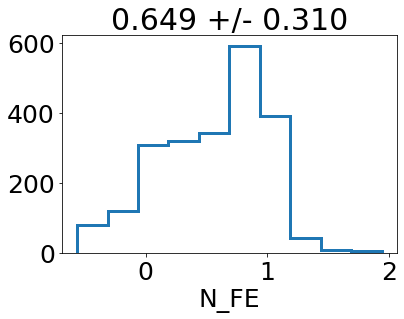

N_FE: min -0.563 max 1.940 sterr 0.043
----------


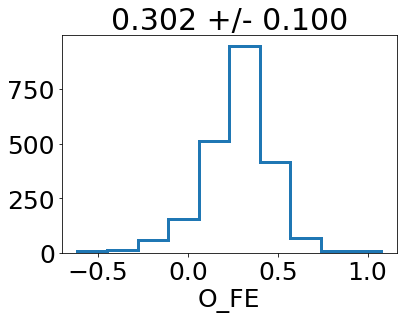

O_FE: min -0.617 max 1.077 sterr 0.044
----------


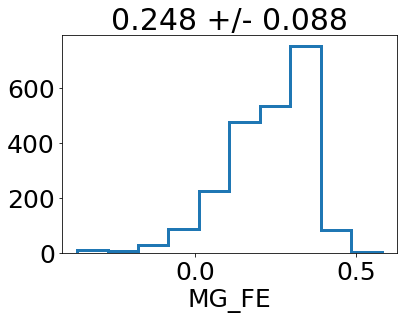

MG_FE: min -0.367 max 0.580 sterr 0.026
----------


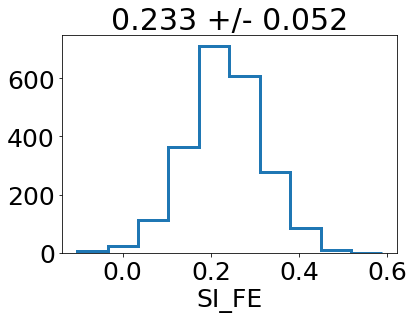

SI_FE: min -0.103 max 0.587 sterr 0.028
----------


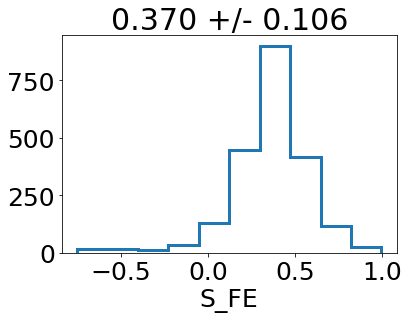

S_FE: min -0.751 max 0.997 sterr 0.115
----------


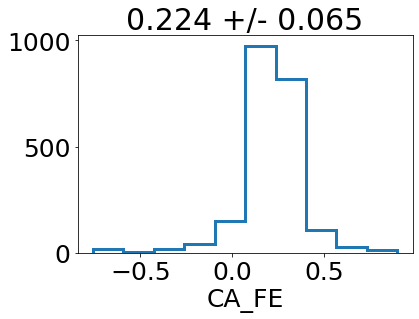

CA_FE: min -0.759 max 0.900 sterr 0.037
----------


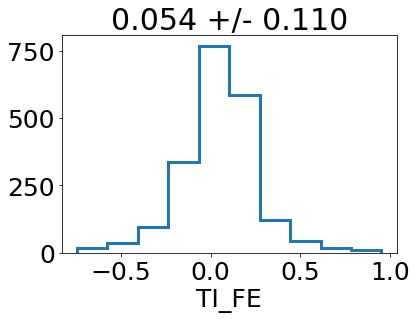

TI_FE: min -0.746 max 0.953 sterr 0.043
----------
PHOTOMETRY


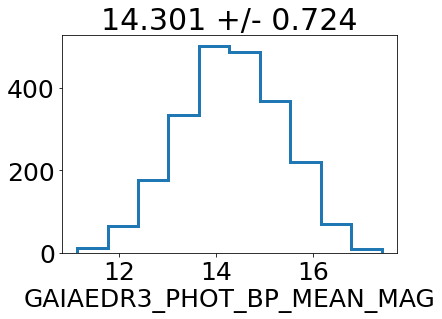

GAIAEDR3_PHOT_BP_MEAN_MAG: min 11.137 max 17.414 sterr 0.003
----------


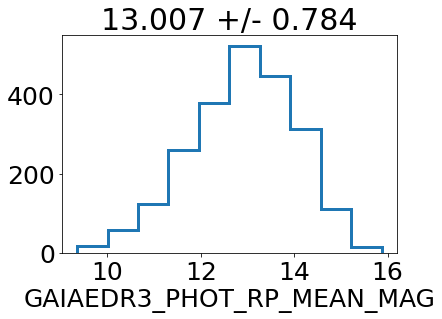

GAIAEDR3_PHOT_RP_MEAN_MAG: min 9.353 max 15.872 sterr 0.004
----------


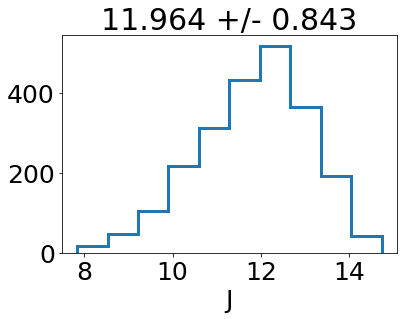

J: min 7.842 max 14.726 sterr 0.025
----------


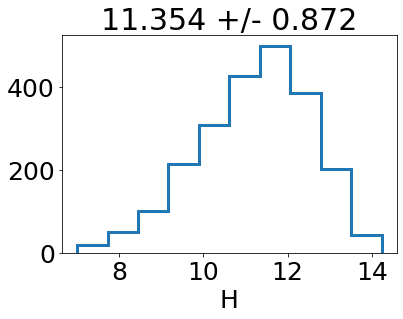

H: min 7.005 max 14.232 sterr 0.026
----------


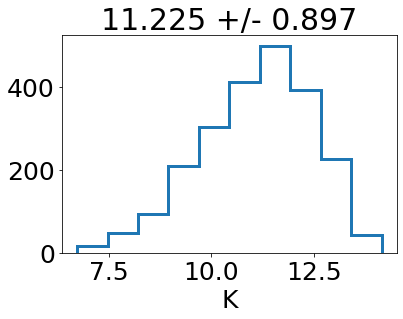

K: min 6.737 max 14.136 sterr 0.024
----------


In [23]:
print('Number of Clusters',len(np.unique(gcs['CLUSTER'])))

### TEFF
print(r'TEFF')
plt.hist(gcsdr17['TEFF'],histtype='step',lw=3.0)
plt.title(r'{:.3f} +/- {:.3f}'.format(np.nanmedian(gcsdr17['TEFF']),mad(gcsdr17['TEFF'])))
plt.xlabel(r'TEFF')
plt.show()
print('TEFF: min {:.3f} max {:.3f} sterr {:.3f}'.format(np.nanmin(gcsdr17['TEFF']),np.nanmax(gcsdr17['TEFF']),
                                                        np.nanmedian(gcsdr17['TEFF_ERR'])))
print(r'----------')

### [Fe/H] + Abundances
print(r'ABUNDANCES')
abund_labs = ['FE_H','C_FE','N_FE','O_FE','MG_FE','SI_FE','S_FE','CA_FE','TI_FE']
for i in range(9):
    plt.figure()
    plt.hist(gcsdr17[abund_labs[i]],histtype='step',lw=3.0)
    plt.title(r'{:.3f} +/- {:.3f}'.format(np.nanmedian(gcsdr17[abund_labs[i]]),mad(gcsdr17[abund_labs[i]])))
    plt.xlabel(abund_labs[i])
    plt.show()
    print('{}: min {:.3f} max {:.3f} sterr {:.3f}'.format(abund_labs[i],np.nanmin(gcsdr17[abund_labs[i]]),
                                                          np.nanmax(gcsdr17[abund_labs[i]]),
                                                          np.nanmedian(gcsdr17[abund_labs[i]+'_ERR'])))
    print(r'----------')
    
### Photometry
print(r'PHOTOMETRY')
phot_labs = ['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K']
phot_err = [bperr,rperr,gcsdr17['J_ERR'],gcsdr17['H_ERR'],gcsdr17['K_ERR']]
for i in range(5):
    plt.figure()
    plt.hist(gcsdr17[phot_labs[i]],histtype='step',lw=3.0)
    plt.title(r'{:.3f} +/- {:.3f}'.format(np.nanmedian(gcsdr17[phot_labs[i]]),mad(gcsdr17[phot_labs[i]])))
    plt.xlabel(phot_labs[i])
    plt.show()
    
    print('{}: min {:.3f} max {:.3f} sterr {:.3f}'.format(phot_labs[i],np.nanmin(gcsdr17[phot_labs[i]]),
                                                          np.nanmax(gcsdr17[phot_labs[i]]),
                                                          np.nanmedian(phot_err[i])))
    print(r'----------')

In [43]:
abp_ebv = cardelli_alav(leff['BP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
arp_ebv = cardelli_alav(leff['RP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
aj_ebv = cardelli_alav(leff['J'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ah_ebv = cardelli_alav(leff['H'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ak_ebv = cardelli_alav(leff['K'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))

In [44]:
# synteff = np.random.normal(10**isochr['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isochr))
# synfeh = np.random.normal(m22_vanfeh,np.nanmedian(gcsdr17['FE_H_ERR']),len(isochr))
# synbpmag = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0
# synrpmag = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0
# synjmag = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0
# synhmag = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0
# synkmag = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0

# synbpmagext = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0+0.34*abp_ebv
# synrpmagext = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0+0.34*arp_ebv
# synjmagext = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*aj_ebv
# synhmagext = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ah_ebv
# synkmagext = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ak_ebv

# synbpmagerr = np.random.normal(np.nanmedian(bperr),mad(bperr),len(isochr))
# synrpmagerr = np.random.normal(np.nanmedian(rperr),mad(rperr),len(isochr))
# synjmagerr = np.random.normal(np.nanmedian(gcsdr17['J_ERR']),mad(gcsdr17['J_ERR']),len(isochr))
# synhmagerr = np.random.normal(np.nanmedian(gcsdr17['H_ERR']),mad(gcsdr17['H_ERR']),len(isochr))
# synkmagerr = np.random.normal(np.nanmedian(gcsdr17['K_ERR']),mad(gcsdr17['K_ERR']),len(isochr))

In [83]:
# for i in tqdm_notebook(range(len(gcs_clus)),leave=False):
#     clus = np.where(gcs['CLUSTER']==gcs_clus[i])
#     clus_iso = massive[np.where((massive['MH']==closest(massive['MH'],np.median(all_sal_feh[clus])))&
#                                 (massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9))))]
    
#     print('VandenBerg',vanden_age[i])
#     print('Closest',np.round(10**closest(massive['logAge'],np.log10(vanden_age[i]*10**9))/10**9,2))
#     print('Closest',np.round(closest(massive['MH'],np.median(all_sal_feh[clus])),2))
#     print('Salaris',np.round(np.median(all_sal_feh[clus]),2))
    
    ### Spectroscopy
    #10**clus_iso['logTe']
#     synteff = np.random.normal(10**clus_iso['logTe'],np.nanmedian(gcsdr17['TEFF_ERR'][clus]),len(clus_iso)) 
#     synfeh = np.random.normal(clus_iso['MH'],np.nanmedian(gcsdr17['FE_H_ERR'][clus]),len(clus_iso))
    
#     print('TEFF',synteff)
#     print('APOGEE Median TEFF',np.nanmedian(gcsdr17['TEFF'][clus]))
#     print('Median Syn TEFF',np.nanmedian(synteff))
#     print('Difference',np.nanmedian(gcsdr17['TEFF'][clus])-np.nanmedian(synteff))
    
#     print('##################################')
#     plt.figure()
#     plt.scatter(clus_iso['logTe'],clus_iso['logg'])
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()
#     plt.show()

TEFF [4053.60172926 4080.16755617 4103.89689592 4137.92893388 4166.80548704
 4181.39026468 4220.32269163 4227.6777692  4266.8905328  4306.56795457
 4345.59765972 4364.91406149 4392.18270846 4417.24806017 4442.57484188
 4489.01757416 4503.84709563 4037.7135351  3981.96992584 3965.57073334
 3942.85181184 3514.73466979 3505.57949466 3554.96958579 3573.98259242
 3596.84147639 3630.54269446 3641.98209722 3705.95730371 3719.93803137
 3753.36195713 3771.33729468 3815.16780273 3840.92924448 3859.90874601
 3900.4458347  3667.86986402 4547.14195325 4579.24390524 4580.60922471
 4630.12527623 5067.86408152 5081.0969632  5087.94494381 5082.44099814
 5119.13313152 5123.85707774 5135.31802123 5161.21510913 5170.66742247
 5214.97673658 5043.65598449 5036.69167398 5014.94045569 4993.34553645
 4647.933654   4684.21777711 4706.14594028 4737.92347557 4731.06006702
 4679.98005276 4717.50674413 4729.98719189 4768.51660779 4812.69858901
 4827.30551677 4857.61221446 4886.93077665 4901.92535276 4906.47996239
 

TEFF [4350.70615711 4413.36975416 4377.94289259 4462.22975475 4466.49187783
 4499.63141755 4531.9285652  4569.71551042 4588.76538157 4649.82420011
 4629.99465    4291.57495508 4304.48113018 4269.39566612 4217.64764658
 4026.92819755 4076.03461922 4039.77307109 4095.39058167 4140.31438427
 4169.68755075 4153.02350129 4186.95241354 4663.91063458 4719.89039203
 4770.84826855 5455.06059993 5462.27226271 5412.82046559 5383.22192083
 5438.13554683 5352.78877419 5318.43901747 5334.64183293 4790.44266299
 4804.93229847 4841.10107563 4876.10801906 4863.32731292 4900.23029078
 4941.52982748 4920.78498344 4916.58226109 4920.89595778 4940.42031334
 4981.53249434 5004.21625137 5028.60106048 5031.75242859 5056.10319838
 5085.61215845 5116.45798439 5120.09514389 5173.57140794 5173.83387293
 5205.57087753 5211.3947821  5220.96846919 5280.5379971  5275.87835852
 5298.79707232 4708.04781695]
APOGEE Median TEFF 4795.3057
Median Syn TEFF 4869.717665990514
Difference -74.41200192801443
####################

TEFF [5099.87312705 5119.71337349 5113.4439761  5052.61305617 4985.65879997
 4996.98250013 5016.97908153 4986.15242187 5036.71652891 5401.11460654
 4954.71186319 4957.66788288 5272.78062847 5235.09441038 5249.55940111
 5432.99267624 5210.74406812 5165.16570278 5184.49051711 5173.12627125
 5159.44170311 4496.90362882 4518.19731188 4533.96097248 4570.98428558
 4615.87762894 4611.71368063 4649.5257334  5307.64942337 4659.08663256
 5329.05452722 5449.16627416 5391.28422347 5398.0564892  5334.6072801
 5329.31239114 4953.99444585 4706.80769288 4730.61760351 5389.30846207
 4746.30255859 4792.9439841  4795.97093874 4830.12173375 4822.0750685
 4858.14751099 4889.69371793 4899.0464108  4928.923304   4950.15470453
 4671.16870826 5496.85182588 5531.06567223 5526.82069236 4363.71245469
 4390.35451806 4408.21657593 4462.35700999 4482.8202635 ]
APOGEE Median TEFF 4763.9736
Median Syn TEFF 4985.658799967098
Difference -221.68516715459828
##################################
TEFF [4421.23617256 4430.9423

TEFF [5134.31349075 5139.60188474 3709.63658088 3744.2583414  3797.43690194
 3819.98506402 3869.32314983 3880.11387898 3915.73370103 3970.96503562
 3970.54494151 4002.77298445 4057.99389136 4056.82741631 4086.32313558
 4136.90559173 4161.72377803 4192.59572291 3385.37291611 3429.29901506
 3464.04325802 3512.25070671 3529.71199615 3571.84497996 3602.82248978
 3650.86331269 3683.19508438 4229.63880769 4235.70720596 4282.37143037
 4787.90862905 4829.02441744 4839.93089878 4870.94997972 4885.29497699
 4896.80791384 4934.75722157 4933.19919611 4969.06501751 4969.68662609
 4977.77766637 5003.22158864 5025.16587801 5042.51379871 5051.77381079
 5044.71252027 5082.72050445 5086.05639596 5107.75462359 4757.05038527
 4747.78354312 4727.41986433 4680.15690234 4289.34433611 4320.95827645
 4357.74640916 4381.18239181 4388.28345553 4420.25075335 4471.4324097
 4497.54172096 4525.39919418 4564.52724044 4600.67473301 4646.67915081
 4672.43187221 4717.82048905 4699.0126311  4678.75411332 4642.13377719
 4

In [68]:
calc_clus_aks = 99999.0*np.ones(len(gcs_clus))
for i in tqdm_notebook(range(len(gcs_clus)),leave=False):
    clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    clus_iso = massive[np.where((massive['MH']==closest(massive['MH'],np.median(all_sal_feh[clus])))&
                                (massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9))))]
    
    ### Spectroscopy
    synteff = np.random.normal(10**clus_iso['logTe'],np.nanmedian(gcsdr17['TEFF_ERR'][clus]),len(clus_iso)) 
    synfeh = np.random.normal(clus_iso['MH'],np.nanmedian(gcsdr17['FE_H_ERR'][clus]),len(clus_iso)) 
    
    ### Photometry
    synbpmag = (np.random.normal(clus_iso['G_BPmag'],np.nanmedian(bperr[clus]),len(clus_iso))+
                5*np.log10(harris_dist[i])-5.0)
    synrpmag = (np.random.normal(clus_iso['G_RPmag'],np.nanmedian(rperr[clus]),len(clus_iso))+
                5*np.log10(harris_dist[i])-5.0)
    synjmag = (np.random.normal(clus_iso['Jmag'],np.nanmedian(gcsdr17['J_ERR'][clus]),len(clus_iso))+
               5*np.log10(harris_dist[i])-5.0)
    synhmag = (np.random.normal(clus_iso['Hmag'],np.nanmedian(gcsdr17['H_ERR'][clus]),len(clus_iso))+
               5*np.log10(harris_dist[i])-5.0)
    synkmag = (np.random.normal(clus_iso['Ksmag'],np.nanmedian(gcsdr17['K_ERR'][clus]),len(clus_iso))+
               5*np.log10(harris_dist[i])-5.0)
    
    synbpmagerr = np.random.normal(np.nanmedian(bperr[clus]),mad(bperr[clus]),len(clus_iso))
    synrpmagerr = np.random.normal(np.nanmedian(rperr[clus]),mad(rperr[clus]),len(clus_iso))
    synjmagerr = np.random.normal(np.nanmedian(gcsdr17['J_ERR'][clus]),mad(gcsdr17['J_ERR'][clus]),len(clus_iso))
    synhmagerr = np.random.normal(np.nanmedian(gcsdr17['H_ERR'][clus]),mad(gcsdr17['H_ERR'][clus]),len(clus_iso))
    synkmagerr = np.random.normal(np.nanmedian(gcsdr17['K_ERR'][clus]),mad(gcsdr17['K_ERR'][clus]),len(clus_iso))
    
    print(harris_ext[i])
   
    
    ### Find Extinctions
    fitaks = 999999.0*np.ones(len(clus_iso))
    for j in tqdm_notebook(range(len(clus_iso)),leave=False):
        cnalpha = np.zeros(8)
        phots = np.array([synbpmag[j]+harris_ext[i]*abp_ebv,synrpmag[j]+harris_ext[i]*arp_ebv,
                          synjmag[j]+harris_ext[i]*aj_ebv,synhmag[j]+harris_ext[i]*ah_ebv,
                          synkmag[j]+harris_ext[i]*ak_ebv])
        phots_err = np.array([synbpmagerr[j],synrpmagerr[j],synjmagerr[j],synhmagerr[j],synkmagerr[j]])
        
        CalcAge = AetasStellae(synteff[j],synfeh[j],cnalpha,phots,phots_err,harris_dist[i],massive)

        CalcAge.extinct(vanden_age[i])
        fitaks[i] = CalcAge.ak
    
    print(fitaks)   
    calc_clus_aks[i] == np.median(fitaks)
    print(r'----------')

0.04


[8.12530282e-03 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.999990

[9.99999000e+05 1.03477721e-01 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05]
----------
0.33


[9.99999000e+05 9.99999000e+05 1.24558382e-01 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
 9.99999000e+05 9.999990

[9.9999900e+05 9.9999900e+05 9.9999900e+05 6.9826969e-02 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05 9.9999900e+05
 9.9999900e+05 9.9999900e+05 9.9999900e+05]
----------
0.02


KeyboardInterrupt: 

In [61]:
print(harris_ext)

[0.04 0.28 0.33 0.19 0.02 0.1  0.38 0.06 0.34 0.01 0.35 0.03 0.02 0.15
 0.08 0.05 0.25 0.01 0.02 0.02 0.22 0.03 0.24 0.05 0.01 0.   0.54 0.37
 0.04 0.77]


In [59]:
print(calc_clus_aks)

[-99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999.
 -99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999.
 -99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999. -99999.
 -99999. -99999. -99999.]


In [ ]:
### Con Extinción 
bf_params_ext = -999999.0*np.ones((len(isochr),2))
bf_params_ext_err = -999999.0*np.ones((len(isochr),2))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmagext[i],synrpmagext[i],synjmagext[i],synhmagext[i],synkmagext[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    best_fit_params_ext,best_fit_params_ext_err = CalcAge.fit()
    
    bf_params_ext[i] = best_fit_params_ext
    bf_params_ext_err[i] = best_fit_params_ext_err

Best Fit Params [Age, Ak]: [8.6   0.151]
Best Fit Params Err [Age, Ak]: [0.466 0.005]
Best Fit [BP,RP,J,H,K]:  [13.33  11.727 10.436  9.767  9.598]
Obs Phot [BP,RP,J,H,K]:  [13.33  11.727 10.54   9.899  9.749]
Obs Phot Err [BP,RP,J,H,K]:  [3.000e-03 4.000e-03 1.054e+01 9.899e+00 9.749e+00]


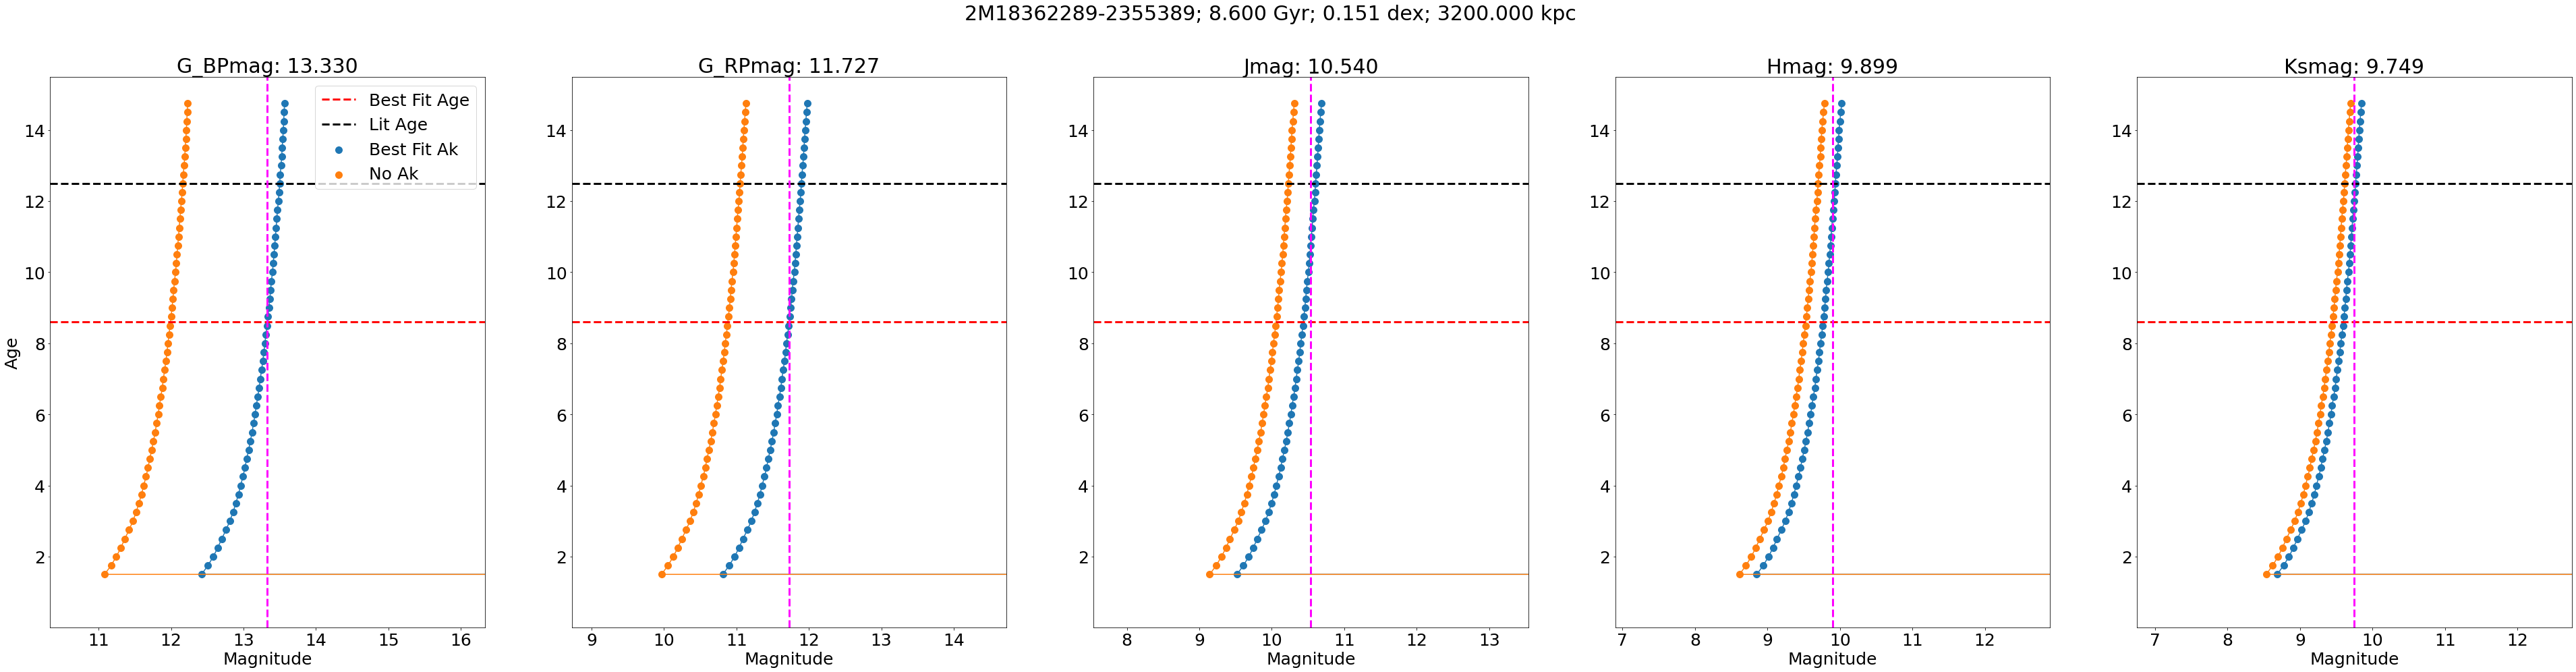

In [12]:
# bf_params = -999999.0*np.ones((len(gcs),2))
# bf_params_err = -999999.0*np.ones((len(gcs),2))
i = 100
cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                    gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
phots = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                  gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
phots_err = np.array([bperr[i],rperr[i],gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
CalcAge = AetasStellae(gcsdr17['TEFF'][i],m22_shiftfeh[i],cnalpha,phots,phots_err,3200,massive)
best_fit_params,best_fit_params_err = CalcAge.fit(verbose=True)
    
# bf_params[i] = best_fit_params
# bf_params_err[i] = best_fit_params_err

CalcAge.diagnostic(best_fit_params,star_name=gcsdr17['APOGEE_ID'][i],lit_age=12.5)

In [13]:
CalcAge.extinct(12.5,verbose=True)
m22_harrak

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4795.3057, -1.4546012224846194]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6808164, 3.6099, 3.7394]
 
-0.03722 x + 3.012
3.6808164
2.8747434832133423
3.5807009
 
-0.000687 x + 1.445
3.6808164
1.4423256836813572
1.9782
 
-0.000708 x + 0.6225
3.6808164
0.6199239767444066
0.79100037
 
-0.03727 x + 0.5499
3.6808164
0.412676427371923
0.15000057
[ebpk,erpk,ejk,ehk]:  [1.03423361 0.54193326 0.17732041 0.06602883]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.13167569 0.1179051  0.11899123 0.11436084]
Calc Ak:  0.11844816513721348


0.1270226992602445

In [14]:
gcsdr17['TEFF']

array([5057.326 , 4990.206 , 4902.433 , 5059.2627, 4967.4263, 4610.9033,
       5057.371 , 4975.369 , 5112.7905, 4823.4595, 4779.829 , 4961.4624,
       5067.098 , 4968.6475, 5045.279 , 4885.4614, 4827.7163, 5052.5337,
       4986.6626, 4665.376 , 4755.0425, 4900.766 , 4943.371 , 4337.006 ,
       4925.4907, 4663.4863, 4768.6665, 4781.307 , 5081.7417, 5029.4272,
       4903.3535, 4865.654 , 4909.462 , 4910.1333, 4767.607 , 4988.7   ,
       4794.902 , 5028.43  , 4614.792 , 5062.251 , 4966.3906, 5020.1895,
       5035.5303, 4666.562 , 5084.3677, 5013.89  , 5114.7393, 4653.3545,
       4954.1255, 4933.5474, 4911.7466, 4438.709 , 4876.047 , 4908.035 ,
             nan, 4092.9746, 4681.401 , 5040.619 , 5002.6777, 4693.165 ,
       4907.327 , 4660.4624, 4890.131 , 4938.2075, 4801.5366, 4685.5967,
       5103.849 , 4988.004 , 4274.0186, 4976.301 , 4667.2363, 4840.8525,
       4381.947 , 4688.607 , 4726.5996, 4850.2866, 4708.7   , 4800.7793,
       4468.2866, 4629.5   , 4506.497 , 4812.1504, 

In [15]:
m22_ext = -999999.0*np.ones(len(gcs))
for i in tqdm_notebook(range(len(gcs))):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    phots = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                      gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    phots_err = np.array([bperr[i],rperr[i],gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    CalcAge = AetasStellae(gcsdr17[i]['TEFF'],m22_shiftfeh[i],cnalpha,phots,phots_err,3200,massive)
    
    CalcAge.extinct(12.5)
    m22_ext[i] = CalcAge.ak

In [17]:
mad(m22_ext)

0.012751007630698794

Text(0.5, 1.0, '12.5 Gyr Extinction')

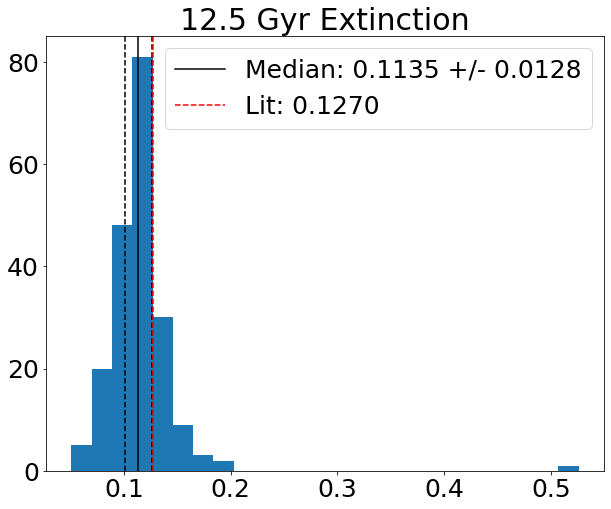

In [18]:
plt.figure(figsize=[10,8])
plt.hist(m22_ext,bins=25)
plt.axvline(np.nanmedian(m22_ext),c='k',ls='-',
            label='Median: {:.4f} +/- {:.4f}'.format(np.nanmedian(m22_ext),mad(m22_ext)))
plt.axvline(np.nanmedian(m22_ext)+mad(m22_ext),c='k',ls='--')
plt.axvline(np.nanmedian(m22_ext)-mad(m22_ext),c='k',ls='--')
plt.axvline(m22_harrak,c='r',ls='--',label='Lit: {:.4f}'.format(m22_harrak))
plt.legend()
plt.title(r'12.5 Gyr Extinction')

In [19]:
m22_ext1_5 = -999999.0*np.ones(len(gcs))
for i in tqdm_notebook(range(len(gcs))):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    phots = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                      gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    phots_err = np.array([bperr[i],rperr[i],gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    CalcAge = AetasStellae(gcsdr17[i]['TEFF'],m22_shiftfeh[i],cnalpha,phots,phots_err,3200,massive)
    
    CalcAge.extinct(12.5)
    m22_ext1_5[i] = CalcAge.ak

Text(0.5, 1.0, '1.5 Gyr extinction')

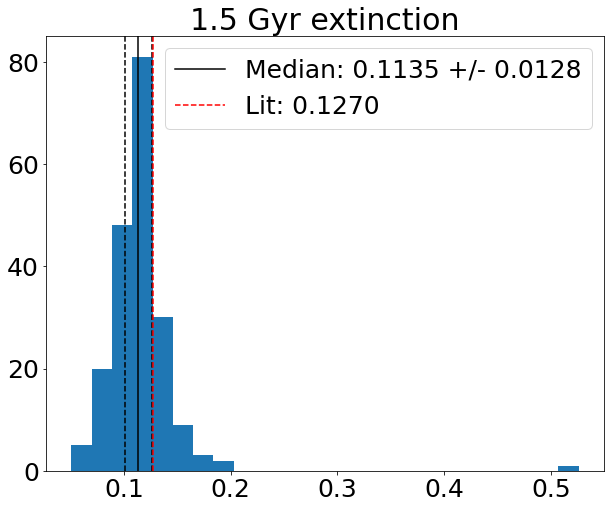

In [20]:
plt.figure(figsize=[10,8])
plt.hist(m22_ext1_5,bins=25)
plt.axvline(np.nanmedian(m22_ext1_5),c='k',ls='-',
            label='Median: {:.4f} +/- {:.4f}'.format(np.nanmedian(m22_ext1_5),mad(m22_ext1_5)))
plt.axvline(np.nanmedian(m22_ext1_5)+mad(m22_ext1_5),c='k',ls='--')
plt.axvline(np.nanmedian(m22_ext1_5)-mad(m22_ext1_5),c='k',ls='--')
plt.axvline(m22_harrak,c='r',ls='--',label='Lit: {:.4f}'.format(m22_harrak))
plt.legend()
plt.title(r'1.5 Gyr extinction')

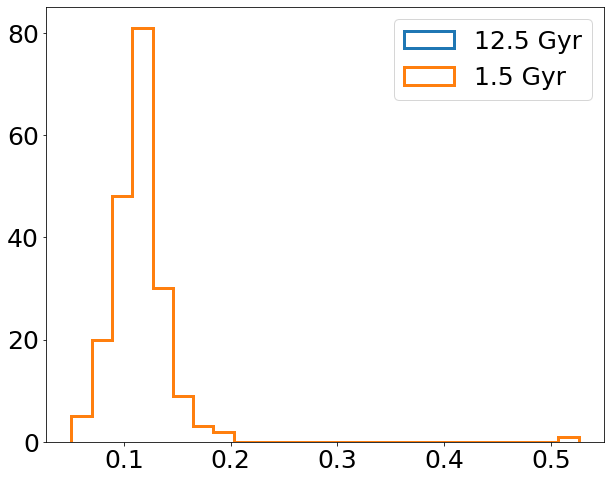

In [21]:
plt.figure(figsize=[10,8])
plt.hist(m22_ext,bins=25,histtype='step',lw=3.0,label='12.5 Gyr')
plt.hist(m22_ext1_5,bins=25,histtype='step',lw=3.0,label='1.5 Gyr')
plt.legend()


In [22]:
m22_ext == m22_ext1_5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

<font size='45'>
    <b>
        Synthetic stars
    </b>
</font>

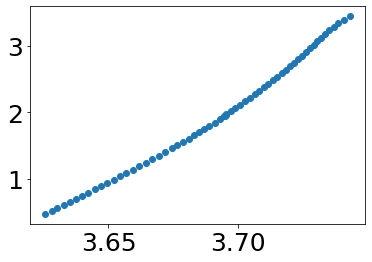

In [23]:
isochr = massive[np.where((massive['MH']==closest(massive['MH'],m22_harfeh))&
                          (massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9))))]

plt.scatter(isochr['logTe'],isochr['logg'])

In [24]:
abp_ebv = cardelli_alav(leff['BP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
arp_ebv = cardelli_alav(leff['RP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
aj_ebv = cardelli_alav(leff['J'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ah_ebv = cardelli_alav(leff['H'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ak_ebv = cardelli_alav(leff['K'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))

In [25]:
synteff = np.random.normal(10**isochr['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isochr))
synfeh = np.random.normal(m22_vanfeh,np.nanmedian(gcsdr17['FE_H_ERR']),len(isochr))
synbpmag = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0
synrpmag = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0
synjmag = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0
synhmag = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0
synkmag = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0

synbpmagext = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0+0.34*abp_ebv
synrpmagext = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0+0.34*arp_ebv
synjmagext = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*aj_ebv
synhmagext = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ah_ebv
synkmagext = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ak_ebv

synbpmagerr = np.random.normal(np.nanmedian(bperr),mad(bperr),len(isochr))
synrpmagerr = np.random.normal(np.nanmedian(rperr),mad(rperr),len(isochr))
synjmagerr = np.random.normal(np.nanmedian(gcsdr17['J_ERR']),mad(gcsdr17['J_ERR']),len(isochr))
synhmagerr = np.random.normal(np.nanmedian(gcsdr17['H_ERR']),mad(gcsdr17['H_ERR']),len(isochr))
synkmagerr = np.random.normal(np.nanmedian(gcsdr17['K_ERR']),mad(gcsdr17['K_ERR']),len(isochr))

# Original Code .fit()

In [26]:
### No Extinction
bf_params = -999999.0*np.ones((len(isochr),2))
bf_params_err = -999999.0*np.ones((len(isochr),2))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmag[i],synrpmag[i],synjmag[i],synhmag[i],synkmag[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    best_fit_params,best_fit_params_err = CalcAge.fit()
    
    bf_params[i] = best_fit_params
    bf_params_err[i] = best_fit_params_err

12.602794469632958

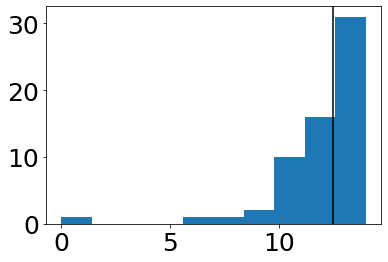

In [27]:
plt.hist(bf_params[:,0],range=(0,14))
plt.axvline(12.5,c='k')
np.nanmedian(bf_params[:,0])

0.0020758031976081037
2.220446049250313e-16
[7.59438636e-03 3.17895572e-03 2.52503831e-03 2.22320279e-03
 4.63755868e-09 2.03816066e-04 3.15544362e-28 1.81782260e-03
 7.67668902e-03 9.17293515e-17 3.25833438e-03 1.36592493e-02
 5.10941442e-18 4.95876729e-04 5.10629664e-27 1.92437884e-03
 2.49616139e-03 1.44494967e-14 2.66902004e-03 1.20409335e-02
 5.15914681e-05 3.23656338e-03 4.45091240e-04 6.25385049e-06
 5.16044890e-03 1.56606838e-04 2.42898694e-03 5.50737392e-05
 1.00000000e-10 2.12673456e-03 3.67817857e-03 2.85449951e-03
 5.91918338e-04 8.41723213e-16 1.78433107e-02 3.16849312e-03
 6.76308740e-05 1.49585504e-03 2.83096200e-03 1.56449439e-04
 2.02487183e-03 6.74946671e-03 7.36441386e-04 2.70795158e-03
 3.38618544e-28 1.62289408e-02 1.06619522e-17 4.02201112e-03
 2.97291199e-20 1.81056698e-02 3.54890276e-03 5.21791798e-03
 1.58748737e-18 1.30408568e-29 3.51590623e-04 2.57260036e-03
 2.43700656e-03 1.02380735e-09 4.35815376e-03 1.01565114e-07
 5.98821426e-03 4.74748016e-03]


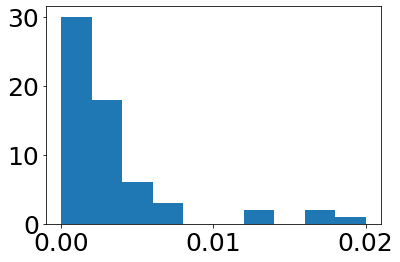

In [28]:
plt.hist(bf_params[:,1],range=(0,0.02))
# plt.axvline(12.5)
print(np.nanmedian(bf_params[:,1]))
print(np.finfo(float).eps)
print(bf_params[:,1])

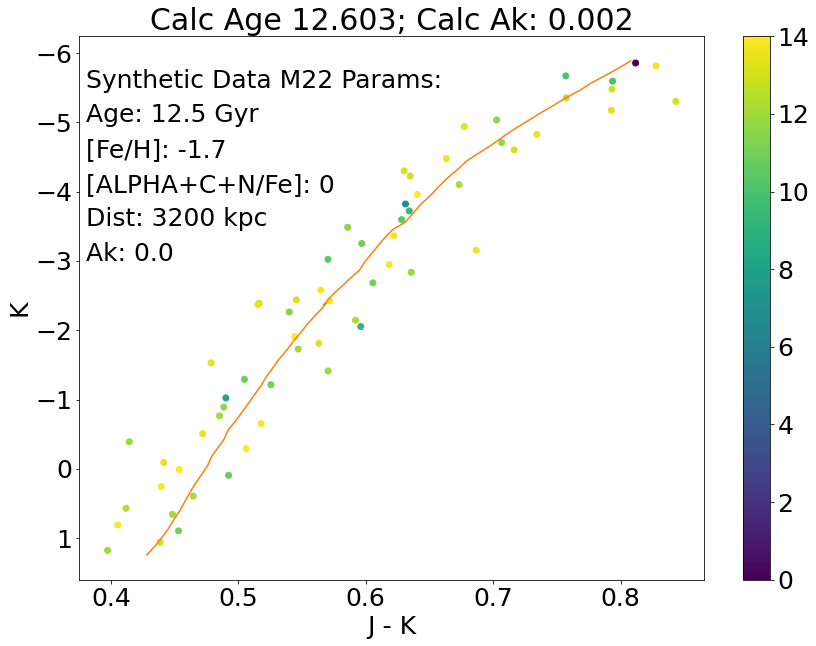

In [29]:
pick = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(synfeh)))&
                (massive['logAge']==closest(massive['logAge'],np.nanmedian(bf_params[:,0]))))
sorte = np.argsort(massive[pick])

plt.figure(figsize=[14,10])
plt.scatter(synjmag-synkmag,synkmag-5.0*np.log10(3200)+5.0,c=bf_params[:,0])
plt.colorbar()
plt.plot((massive['Jmag']-massive['Ksmag'])[pick][sorte],massive['Ksmag'][pick][sorte],c='tab:orange')
plt.gca().invert_yaxis()
plt.title(r'Calc Age {:.3f}; Calc Ak: {:.3f}'.format(np.nanmedian(bf_params[:,0]),np.nanmedian(bf_params[:,1])))
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.text(0.38,-5.5,'Synthetic Data M22 Params:')
plt.text(0.38,-5.0,'Age: 12.5 Gyr')
plt.text(0.38,-4.5,'[Fe/H]: -1.7')
plt.text(0.38,-4.0,'[ALPHA+C+N/Fe]: 0')
plt.text(0.38,-3.5,'Dist: 3200 kpc')
plt.text(0.38,-3.0,'Ak: 0.0')

plt.show()

In [30]:
### Con Extinción 
bf_params_ext = -999999.0*np.ones((len(isochr),2))
bf_params_ext_err = -999999.0*np.ones((len(isochr),2))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmagext[i],synrpmagext[i],synjmagext[i],synhmagext[i],synkmagext[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    best_fit_params_ext,best_fit_params_ext_err = CalcAge.fit()
    
    bf_params_ext[i] = best_fit_params_ext
    bf_params_ext_err[i] = best_fit_params_ext_err

12.617068815756841
[6.54990499e+00 9.37497241e+00 1.00415977e+01 1.14750608e+01
 1.38498480e+01 1.05999789e+01 1.39220098e+01 1.00474778e+01
 1.40000000e+01 1.19250443e+01 1.02534592e+01 1.40000000e+01
 1.37998703e+01 1.22000046e+01 1.33998519e+01 1.30749489e+01
 1.11521789e+01 1.22250318e+01 8.72178729e+00 1.40000000e+01
 1.30999609e+01 1.28591435e+01 1.29500068e+01 1.12500641e+01
 1.40000000e+01 1.14750608e+01 1.34499293e+01 1.35500219e+01
 1.00000000e-10 1.36500737e+01 1.01998787e+01 9.27491625e+00
 1.32750143e+01 1.31250207e+01 1.39749397e+01 1.33499613e+01
 1.16750836e+01 1.37749488e+01 1.40000000e+01 1.12249653e+01
 1.30749489e+01 1.33249322e+01 1.09748856e+01 1.12893223e+01
 1.14499873e+01 1.40000000e+01 1.31749810e+01 1.40000000e+01
 1.33249304e+01 1.40000000e+01 1.08999625e+01 1.40000000e+01
 1.20499433e+01 1.23749941e+01 1.18638460e+01 1.40000000e+01
 1.10112810e+01 1.30206181e+01 1.23307623e+01 1.20998621e+01
 8.29994090e+00 1.21249511e+01]


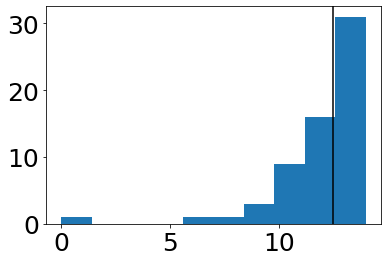

In [31]:
plt.hist(bf_params_ext[:,0],range=(0,14))
plt.axvline(12.5,c='k')
print(np.nanmedian(bf_params_ext[:,0]))
print(bf_params_ext[:,0])

Calc Ak: 0.1288089860394403
Harris Ak: 0.12702269926024454
[1.37310339e-01 1.30121078e-01 1.31331856e-01 1.29451417e-01
 1.26242579e-01 1.28652301e-01 1.26421877e-01 1.30885599e-01
 1.34267244e-01 1.27048273e-01 1.30352034e-01 1.40073782e-01
 1.27160526e-01 1.28096149e-01 1.26279857e-01 1.29892706e-01
 1.29281871e-01 1.27932451e-01 1.33663321e-01 1.38626619e-01
 1.27768347e-01 1.25885332e-01 1.29582566e-01 1.30903736e-01
 1.31455748e-01 1.30288270e-01 1.27229549e-01 1.25223695e-01
 1.00000000e-10 1.29068366e-01 1.30293554e-01 1.33711537e-01
 1.27009013e-01 1.24730306e-01 1.41369468e-01 1.30200895e-01
 1.27550678e-01 1.27150297e-01 1.27832887e-01 1.28594568e-01
 1.28719282e-01 1.34472291e-01 1.27126574e-01 1.27726890e-01
 1.28405819e-01 1.43255377e-01 1.28764564e-01 1.30627094e-01
 1.27200894e-01 1.45344364e-01 1.28710999e-01 1.32130501e-01
 1.27887167e-01 1.27489296e-01 1.28853408e-01 1.29368262e-01
 1.28964041e-01 1.25463087e-01 1.27561868e-01 1.26904467e-01
 1.30422511e-01 1.31424246

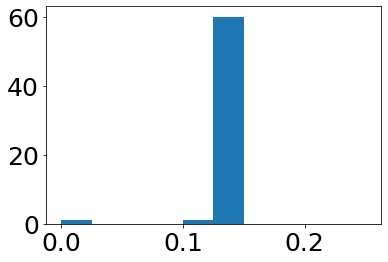

In [32]:
plt.hist(bf_params_ext[:,1],range=(0,0.25))
print('Calc Ak:',np.nanmedian(bf_params_ext[:,1]))
print('Harris Ak:',0.34*ak_ebv)
print(bf_params_ext[:,1])

In [33]:
ejk_ebv = ((cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/
           (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1)))

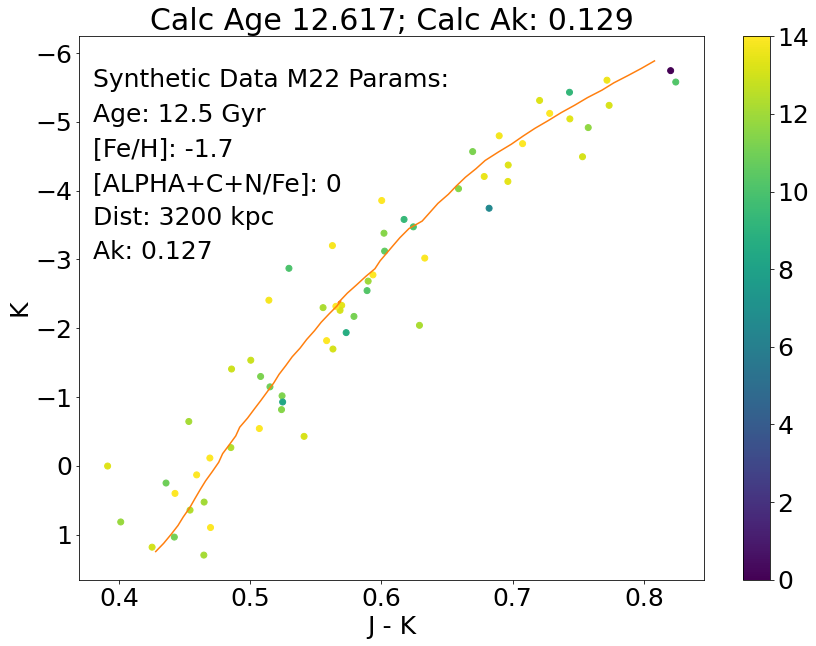

In [34]:
pick_ext = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(synfeh)))&
                (massive['logAge']==closest(massive['logAge'],np.nanmedian(bf_params_ext[:,0]))))
sorte_ext = np.argsort(massive[pick_ext])

plt.figure(figsize=[14,10])
plt.scatter(synjmagext-synkmagext-0.34*ejk_ebv,synkmagext-5.0*np.log10(3200)+5.0,c=bf_params_ext[:,0])
plt.colorbar()
plt.plot((massive['Jmag']-massive['Ksmag'])[pick][sorte],massive['Ksmag'][pick][sorte],c='tab:orange')
plt.gca().invert_yaxis()
plt.title(r'Calc Age {:.3f}; Calc Ak: {:.3f}'.format(np.nanmedian(bf_params_ext[:,0]),
                                                     np.nanmedian(bf_params_ext[:,1])))
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.text(0.38,-5.5,'Synthetic Data M22 Params:')
plt.text(0.38,-5.0,'Age: 12.5 Gyr')
plt.text(0.38,-4.5,'[Fe/H]: -1.7')
plt.text(0.38,-4.0,'[ALPHA+C+N/Fe]: 0')
plt.text(0.38,-3.5,'Dist: 3200 kpc')
plt.text(0.38,-3.0,'Ak: {:.3f}'.format(0.34*ak_ebv))

plt.show()

# Not Original Code

In [42]:
### No Extinction
m22_noext = 999999.0*np.ones(len(isochr))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmag[i],synrpmag[i],synjmag[i],synhmag[i],synkmag[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    CalcAge.extinct(12.5,verbose=True)
    m22_noext[i] = CalcAge.ak
    print('----------')

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4717.838159042694, -1.6848127443454348]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6737430387453696, 3.6245, 3.7407]
 
-0.04074 x + 3.154
3.6737430387453696
3.004253401694661
2.6770436942200107
 
-0.003793 x + 1.53
3.6737430387453696
1.5156129629918904
1.4781798523427874
 
-0.0006135 x + 0.6406
3.6737430387453696
0.6383750811798797
0.6311850710879519
 
-0.0009664 x + 0.09829
3.6737430387453696
0.09473589999695037
0.08304156312915367
[ebpk,erpk,ejk,ehk]:  [ 0.03240627 -0.00395931 -0.00177493 -0.00316495]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [ 0.00412587 -0.0008614  -0.00119107 -0.00548165]
Calc Ak:  -0.0010262360436995885
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4719.029608893646, -1.6867538838006144]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6738527022717022, 3.6251, 3.7384]
 
-0.03555 x + 3.088
3.6738527022717022
2.95766763174

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4922.122519634309, -1.729069964628457]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.692152419797272, 3.6276, 3.7431]
 
0.00412 x + 2.348
3.692152419797272
2.3631852753173126
2.411469204582964
 
-0.00115 x + 1.37
3.692152419797272
1.3661518261503434
1.3733892088144408
 
0.0003749 x + 0.5725
3.692152419797272
0.5738924521273157
0.5646647545946539
 
5.891e-05 x + 0.08379
3.692152419797272
0.08400834010055579
0.1469766815957172
[ebpk,erpk,ejk,ehk]:  [ 0.01199298  0.01736841 -0.01252983  0.06244946]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [ 0.00152691  0.00377874 -0.00840817  0.10816143]
Calc Ak:  0.002652825565301358
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4955.405122656476, -1.699115640494989]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6950791654493527, 3.6257, 3.7407]
 
-2.538e-05 x + 2.364
3.6950791654493527
2.3636208976766007
2.3372

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4935.350743039852, -1.719375596609762]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.693318022325603, 3.6292, 3.7431]
 
-0.0002693 x + 2.389
3.693318022325603
2.388468682938492
2.3584837997175256
 
0.00242 x + 1.318
3.693318022325603
1.327427865825655
1.3223199215644534
 
-9.187e-06 x + 0.573
3.693318022325603
0.5729173367552582
0.5715920961197813
 
0.002407 x + 0.05366
3.693318022325603
0.06255065150720056
0.10183120865415418
[ebpk,erpk,ejk,ehk]:  [-0.02761309 -0.02642205 -0.00124433  0.01808656]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [-0.00351562 -0.00574848 -0.00083501  0.03132563]
Calc Ak:  -0.002175315852792984
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4621.45491769631, -1.695527972005807]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6647787208495837, 3.6257, 3.7407]
 
-0.03901 x + 3.276
3.6647787208495837
3.1329364894012883
2.7921

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4408.436008017488, -1.6789737923940704]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6442845410415075, 3.6245, 3.7407]
 
0.009911 x + 3.027
3.6442845410415075
3.062803229078521
3.1421654147935048
 
0.006162 x + 1.633
3.6442845410415075
1.6557978762861996
1.7010256858409
 
0.006159 x + 0.6505
3.6442845410415075
0.6728958015889525
0.7027036039720329
 
0.001281 x + 0.08064
3.6442845410415075
0.08531068776182531
0.10073732667526158
[ebpk,erpk,ejk,ehk]:  [-0.00840384 -0.00934463 -0.02473068  0.00407866]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [-0.00106995 -0.00203305 -0.01659557  0.00706418]
Calc Ak:  -0.0015515039607204768
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4418.184324299696, -1.6864703185663508]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6452438304481305, 3.6251, 3.7384]
 
0.02834 x + 2.781
3.6452438304481305
2.883790772401856
3.1

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5315.3442373187445, -1.7048319651839692]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.7255313959575, 3.6257, 3.7407]
 
0.004445 x + 1.98
3.7255313959575
1.9966015634197927
1.9801625805807674
 
-0.01641 x + 1.349
3.7255313959575
1.2878116037956617
1.0913168969349059
 
0.03172 x + 0.0802
3.7255313959575
0.19838082092507342
0.441420975027615
 
0.02387 x - 0.228
3.7255313959575
-0.1390561986273645
0.05866826188321994
[ebpk,erpk,ejk,ehk]:  [-0.05543904 -0.05248024 -0.03530172 -0.01171655]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [-0.00705834 -0.0114178  -0.0236893  -0.02029287]
Calc Ak:  -0.015855337282868625
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5308.378949314007, -1.7078599267589498]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.724961918284631, 3.6263, 3.7431]
 
-0.03616 x + 2.494
3.724961918284631
2.3596622907411415
1.9988931748649144


Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5225.405179493997, -1.6841639582260686]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.7181199714138997, 3.6245, 3.7407]
 
0.03227 x + 1.708
3.7181199714138997
1.828480338029457
2.1387752080456934
 
0.03811 x + 0.7137
3.7181199714138997
0.8554288429130662
1.200665239822392
 
0.03486 x + 0.06276
3.7181199714138997
0.19238728180568665
0.49016395533910284
 
0.003109 x + 0.03418
3.7181199714138997
0.04574382786454811
0.029970780865077984
[ebpk,erpk,ejk,ehk]:  [ 0.02687518  0.0105505  -0.00839262 -0.04307898]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [ 0.00342167  0.00229541 -0.00563188 -0.07461208]
Calc Ak:  -0.0016682383434448308
----------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5535.135654426112, -1.7085588705886186]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.743128268981096, 3.6263, 3.7431]
Ak:  999999.0
Ak:  999999.0
 
0.03892 x + 1.372
3.7431282

0.00025104898623462974


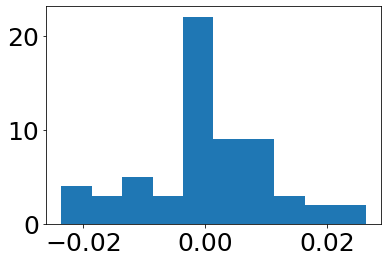

In [47]:
plt.hist(m22_noext)#,range=(0,0.1))
print(np.median(m22_noext))
plt.show()

# plt.hist(m22_noext[np.where(m22_noext<100.)],range=(0,0.1))
# print(np.median(m22_noext[np.where(m22_noext<100.)]))
# plt.show()

In [37]:
np.where(m22_noext>100.)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),)

In [38]:
m22_noext

array([ 9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  9.99999000e+05,  9.99999000e+05,  9.99999000e+05,
        9.99999000e+05,  

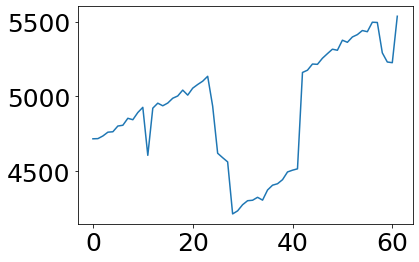

In [39]:
plt.plot(synteff)

In [ ]:
### Run All Stars
guess_ages = np.arange(0,14)

best_ages = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_ages_err = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))
best_chis = 999999.0*np.ones(len(gcsdr17))#np.ones((len(gcs),len(guess_ages),len(guess_aks)))


for i in tqdm_notebook(range(len(gcs))):
    curve_ages = []
    curve_ages_err = []
    curve_chi = []
    
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    CalcAge = AetasStellae(shiftfeh[i],cnalpha,gcs_dist[i],3.1,massive)
    for j in range(len(guess_ages)):
        for k in range(len(guess_aks)):
            try:
                obs_mags = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                                     gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                                     gcsdr17['J'][i],gcsdr17['H'][i],
                                     gcsdr17['K'][i]],dtype=float).T.ravel()
                
                obs_sigs = np.array([bperr[i],rperr[i],gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]],
                                    dtype=float).T.ravel()
                
                popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcsdr17['TEFF'][i],
                                   obs_mags,p0=[guess_ages[j],guess_aks[k]],bounds=((0.,0.),(14.,2.)),
                                   method='trf',sigma=obs_sigs,absolute_sigma=True,maxfev=5000)
            
                curve_ages.append(popt[0])
                curve_aks.append(popt[1])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_aks_err.append(np.sqrt(pcov[1][1]))
                curve_mags = np.asarray(CalcAge.Teff2AppMags(gcsdr17['TEFF'][i],popt[0],popt[1]))
                curve_chi.append(sum((curve_mags-obs_mags)**2/obs_sigs**2))
            
            except:
#                 print([i,j,k])
                curve_ages.append(999999.0)
                curve_aks.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_aks_err.append(999999.0)
                curve_chi.append(999999.0)
                
    best_idx = np.asarray(curve_chi).argmin()
    best_chis[i] = np.min(curve_chi)
    best_ages[i] = np.asarray(curve_ages)[best_idx]
    best_aks[i] = np.asarray(curve_aks)[best_idx]
    best_ages_err[i] = np.asarray(curve_ages_err)[best_idx]
    best_aks_err[i] = np.asarray(curve_aks_err)[best_idx]

In [44]:
### Lit Extinction
m22_litext = 999999.0*np.ones(len(isochr))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmagext[i],synrpmagext[i],synjmagext[i],synhmagext[i],synkmagext[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    CalcAge.extinct(12.5,verbose=True)
    m22_litext[i] = CalcAge.ak
    print('------------')

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4717.838159042694, -1.6848127443454348]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6737430387453696, 3.6245, 3.7407]
 
-0.04074 x + 3.154
3.6737430387453696
3.004253401694661
3.7239329400316894
 
-0.003793 x + 1.53
3.6737430387453696
1.5156129629918904
2.108065722693304
 
-0.0006135 x + 0.6406
3.6737430387453696
0.6383750811798797
0.8712954983866403
 
-0.0009664 x + 0.09829
3.6737430387453696
0.09473589999695037
0.1633088057850518
[ebpk,erpk,ejk,ehk]:  [1.07929552 0.62592656 0.2383355  0.07710229]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.13741285 0.136179   0.15993554 0.13353989]
Calc Ak:  0.13679592415699482
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4719.029608893646, -1.6867538838006144]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6738527022717022, 3.6251, 3.7384]
 
-0.03555 x + 3.088
3.6738527022717022
2.9576676317411477
3.650

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4922.122519634309, -1.729069964628457]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.692152419797272, 3.6276, 3.7431]
 
0.00412 x + 2.348
3.692152419797272
2.3631852753173126
3.3667158051746213
 
-0.00115 x + 1.37
3.692152419797272
1.3661518261503434
1.9151901600011154
 
0.0003749 x + 0.5725
3.692152419797272
0.5738924521273157
0.7035195038205782
 
5.891e-05 x + 0.08379
3.692152419797272
0.08400834010055579
0.15587505900888488
[ebpk,erpk,ejk,ehk]:  [0.96723958 0.55916936 0.12632491 0.07134784]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.1231462  0.12165505 0.0847706  0.12357328]
Calc Ak:  0.12240062529074439
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4955.405122656476, -1.699115640494989]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6950791654493527, 3.6257, 3.7407]
 
-2.538e-05 x + 2.364
3.6950791654493527
2.3636208976766007
3.366169852

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4935.350743039852, -1.719375596609762]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.693318022325603, 3.6292, 3.7431]
 
-0.0002693 x + 2.389
3.693318022325603
2.388468682938492
3.369881956788749
 
0.00242 x + 1.318
3.693318022325603
1.327427865825655
1.930088680567179
 
-9.187e-06 x + 0.573
3.693318022325603
0.5729173367552582
0.7545710715844454
 
0.002407 x + 0.05366
3.693318022325603
0.06255065150720056
0.1276639389030425
[ebpk,erpk,ejk,ehk]:  [0.98378507 0.58134671 0.18173464 0.04391929]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.12525273 0.12648004 0.12195342 0.07606749]
Calc Ak:  0.12360307139197689
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4621.45491769631, -1.695527972005807]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6647787208495837, 3.6257, 3.7407]
 
-0.03901 x + 3.276
3.6647787208495837
3.1329364894012883
3.845083943490154

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4408.436008017488, -1.6789737923940704]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6442845410415075, 3.6245, 3.7407]
 
0.009911 x + 3.027
3.6442845410415075
3.062803229078521
4.154267573095883
 
0.006162 x + 1.633
3.6442845410415075
1.6557978762861996
2.3005219873563245
 
0.006159 x + 0.6505
3.6442845410415075
0.6728958015889525
0.9468143898519479
 
0.001281 x + 0.08064
3.6442845410415075
0.08531068776182531
0.1541645523467654
[ebpk,erpk,ejk,ehk]:  [1.00369832 0.59015167 0.21938011 0.05750589]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.12778803 0.12839568 0.14721548 0.09959925]
Calc Ak:  0.12809185173250004
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 4418.184324299696, -1.6864703185663508]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.6452438304481305, 3.6251, 3.7384]
 
0.02834 x + 2.781
3.6452438304481305
2.883790772401856
4.092636062

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5315.3442373187445, -1.7048319651839692]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.7255313959575, 3.6257, 3.7407]
 
0.004445 x + 1.98
3.7255313959575
1.9966015634197927
3.0125334590421193
 
-0.01641 x + 1.349
3.7255313959575
1.2878116037956617
1.706494733923801
 
0.03172 x + 0.0802
3.7255313959575
0.19838082092507342
0.5806499886967824
 
0.02387 x - 0.228
3.7255313959575
-0.1390561986273645
0.14454036363654588
[ebpk,erpk,ejk,ehk]:  [0.97693183 0.5626976  0.10392729 0.07415555]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.12438019 0.12242267 0.06974063 0.12843619]
Calc Ak:  0.12340142901528994
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5308.378949314007, -1.7078599267589498]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.724961918284631, 3.6263, 3.7431]
 
-0.03616 x + 2.494
3.724961918284631
2.3596622907411415
3.00424522000837
 
0.007258

Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5225.405179493997, -1.6841639582260686]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.7181199714138997, 3.6245, 3.7407]
 
0.03227 x + 1.708
3.7181199714138997
1.828480338029457
3.160983529082957
 
0.03811 x + 0.7137
3.7181199714138997
0.8554288429130662
1.816425433955935
 
0.03486 x + 0.06276
3.7181199714138997
0.19238728180568665
0.7140052258295402
 
0.003109 x + 0.03418
3.7181199714138997
0.04574382786454811
0.16074520660246172
[ebpk,erpk,ejk,ehk]:  [1.0490835  0.6263107  0.21544865 0.08769545]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.13356634 0.13626258 0.14457727 0.15188707]
Calc Ak:  0.14041992413800308
------------
Input [Age, teff, Salaris [Fe/H]]:  [12.5, 5535.135654426112, -1.7085588705886186]
[age_lo,age_hi]:  [12.499999625598079, 12.525065335781754]
lgteff, min, max:  [3.743128268981096, 3.6263, 3.7431]
Ak:  999999.0
Ak:  999999.0
 
0.03892 x + 1.372
3.743128268981096
1.5

0.1268755391034705


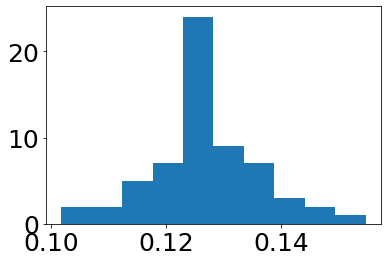

In [46]:
plt.hist(m22_litext)
print(np.median(m22_litext))
plt.show()

# APOGEE Wide GCs

Number of Clusters 1


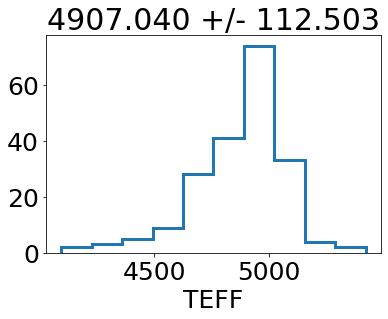

TEFF: min 4092.975 max 5422.819 sterr 18.735
----------


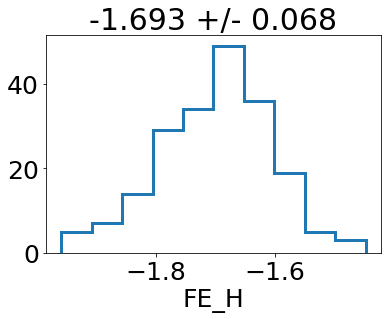

FE_H: min -1.959 max -1.448 sterr 0.015
----------


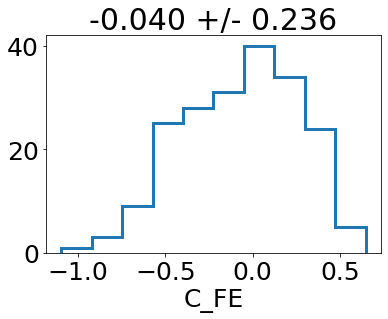

C_FE: min -1.096 max 0.647 sterr 0.074
----------


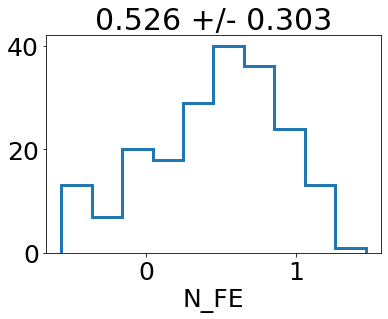

N_FE: min -0.563 max 1.460 sterr 0.075
----------


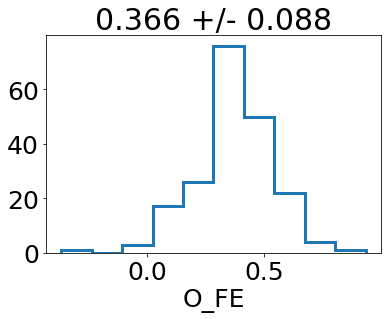

O_FE: min -0.366 max 0.935 sterr 0.069
----------


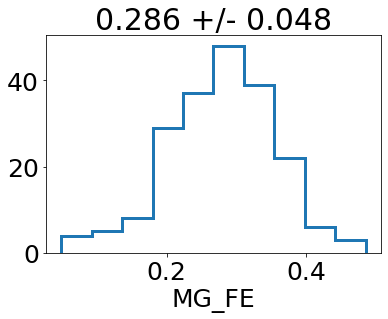

MG_FE: min 0.049 max 0.486 sterr 0.035
----------


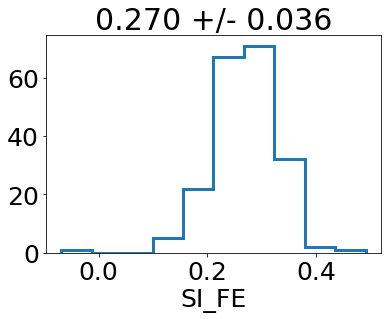

SI_FE: min -0.069 max 0.492 sterr 0.036
----------


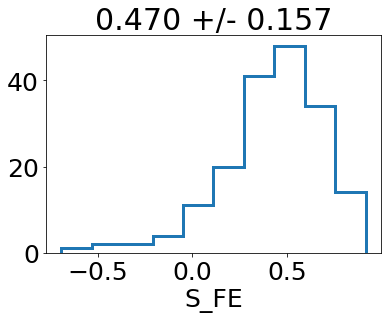

S_FE: min -0.692 max 0.917 sterr 0.169
----------


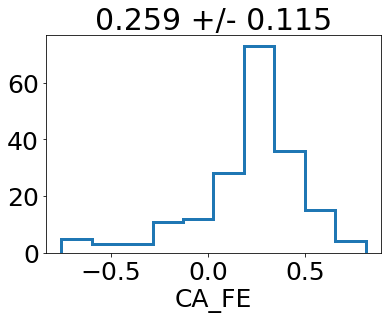

CA_FE: min -0.757 max 0.811 sterr 0.056
----------


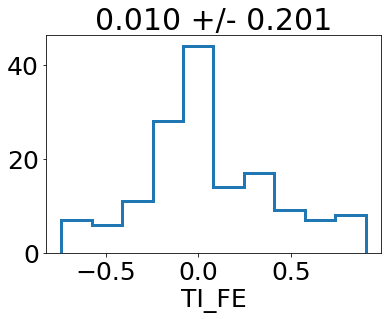

TI_FE: min -0.739 max 0.901 sterr 0.055
----------


In [ ]:
bf_params = -999999.0*np.ones((len(gcs),2))
bf_params_err = -999999.0*np.ones((len(gcs),2))
for i in tqdm_notebook(range(len(gcs))):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    phots = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                      gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    phots_err = np.array([bperr[i],rperr[i],gcsdr17['J'][i],gcsdr17['H'][i],gcsdr17['K'][i]])
    
    CalcAge = AetasStellae(gcsdr17['TEFF'][i],m22_shiftfeh[i],cnalpha,phots,phots_err,3200,massive)
    best_fit_params,best_fit_params_err = CalcAge.fit()
    
    bf_params[i] = best_fit_params
    bf_params_err[i] = best_fit_params_err
    
    CalcAge.diagnostic(best_fit_params,star_name=gcsdr17['APOGEE_ID'][i],lit_age=12.5)#,
#                        filename='../plots/m22diagnostic/{}diagnostic.png'.format(gcsdr17['APOGEE_ID'][i]))

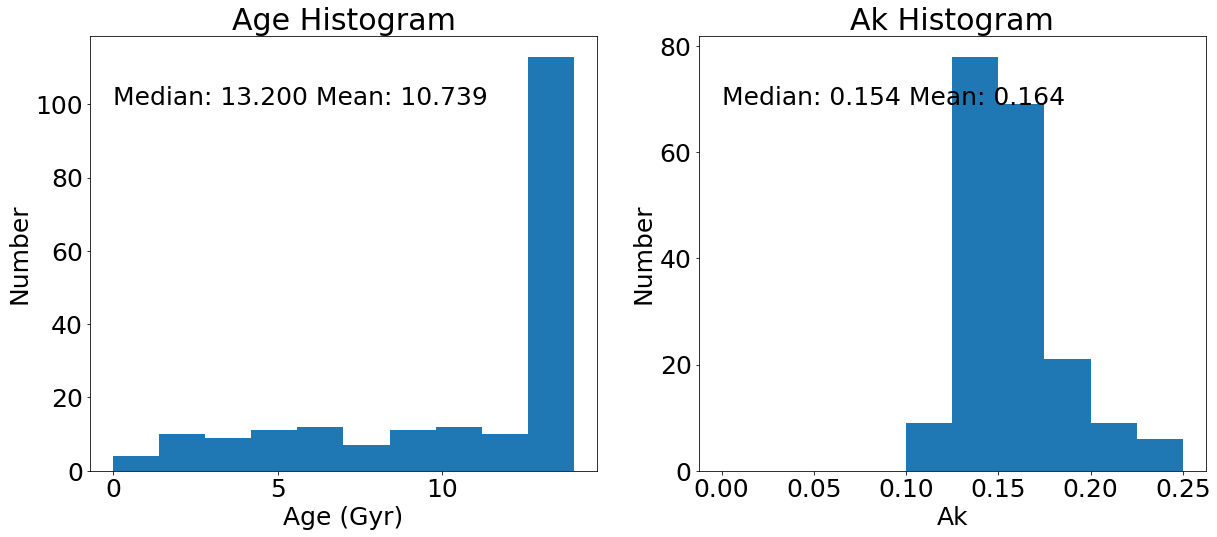

In [33]:
good = np.where((bf_params[:,0]>-1.)&(bf_params[:,0]<15.))

plt.figure(figsize=[20,8])
plt.subplot(121)
plt.hist(bf_params[:,0],range=(0,14))
plt.text(0,100,'Median: {:.3f} Mean: {:.3f}'.format(np.median(bf_params[:,0][good]),np.mean(bf_params[:,0][good])))
plt.title(r'Age Histogram')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Number')
plt.subplot(122)
plt.hist(bf_params[:,1],range=(0,0.25))
plt.text(0,69,'Median: {:.3f} Mean: {:.3f}'.format(np.median(bf_params[:,1][good]),np.mean(bf_params[:,1][good])))
plt.title(r'Ak Histogram')
plt.xlabel(r'Ak')
plt.ylabel(r'Number')
# plt.savefig('../plots/M22AgeAk.pdf',bbox_inches='tight')
plt.show()

In [12]:
print(np.median(bf_params[:,0]))
print(np.median(bf_params[:,1]))

13.209140653266914
0.15426919102048264


In [79]:
ebprp_ak = ((cardelli_alav(leff['BP'],3.1)-cardelli_alav(leff['RP'],3.1))/cardelli_alav(leff['K'],3.1))
ebprp_ak

3.2580489086437394

In [89]:
ebprp_jk = ((cardelli_alav(leff['BP'],3.1)-cardelli_alav(leff['RP'],3.1))/
            (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1)))

ebprp_bv = ((cardelli_alav(leff['BP'],3.1)-cardelli_alav(leff['RP'],3.1))/
            (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1)))


print('Harris',0.34*ebprp_bv)

# Variable stars in the VVV globular clusters. II. NGC 6441, NGC 6569, NGC 6626 (M 28), NGC 6656 (M 22), 2MASS-GC 02, and Terzan 10
print('Alonso-García',0.18*ebprp_ak)#Javier Alonso-García et al. 2021 

print('Calculated',np.median(bf_params[:,1][good])*ebprp_ak)

Harris 0.41384616669782165
Alonso-García 0.586448803555873
Calculated 0.5010493760265271


In [90]:
np.median(m22_shiftfeh)

-1.6970000386238098

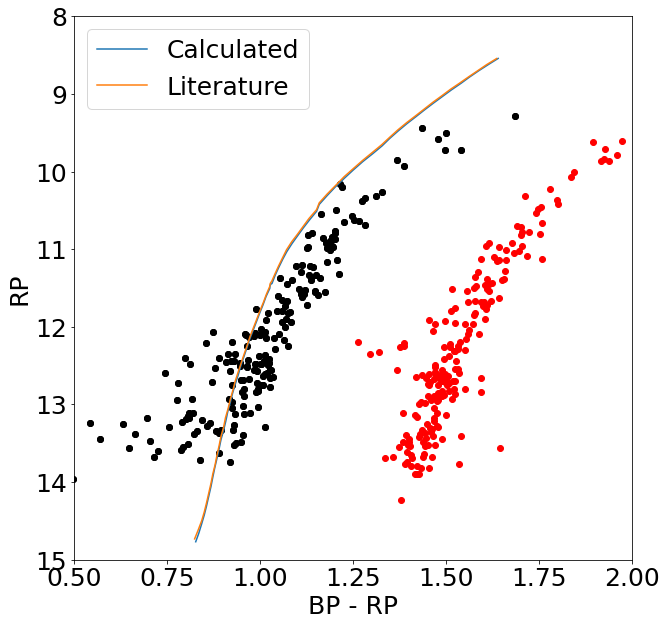

In [88]:
calc_iso = np.where(
    (massive['logAge']==closest(massive['logAge'],np.log10(np.median(bf_params[:,0][good])*10**9)))&
    (massive['MH']==closest(massive['MH'],np.median(m22_shiftfeh))))
calc_sort = np.argsort(massive['logTe'][calc_iso])

lite_iso = np.where(
    (massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&
    (massive['MH']==closest(massive['MH'],-1.70)))
lite_sort = np.argsort(massive['logTe'][lite_iso])

plt.figure(figsize=[10,10])
# plt.subplot(121)
plt.plot((massive['G_BPmag']-massive['G_RPmag'])[calc_iso][calc_sort],
         massive['G_RPmag'][calc_iso][calc_sort]+5.0*np.log10(3200)-5.0,label='Calculated')
plt.plot((massive['G_BPmag']-massive['G_RPmag'])[lite_iso][lite_sort],
         massive['G_RPmag'][lite_iso][lite_sort]+5.0*np.log10(3200.)-5.0,label='Literature')

plt.legend()

plt.scatter(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ebprp_ak*bf_params[:,1],
            gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-bf_params[:,1],c='k')
plt.scatter(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ebprp_ak*bf_params[:,1],
            gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-bf_params[:,1],c='k')
plt.scatter(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'],
            gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'],c='r')

plt.xlim(0.5,2.0)
plt.ylim(8,15)
plt.gca().invert_yaxis()

plt.xlabel(r'BP - RP')
plt.ylabel(r'RP')

# plt.savefig('../plots/M22GaiaCMD.pdf',bbox_inches='tight');

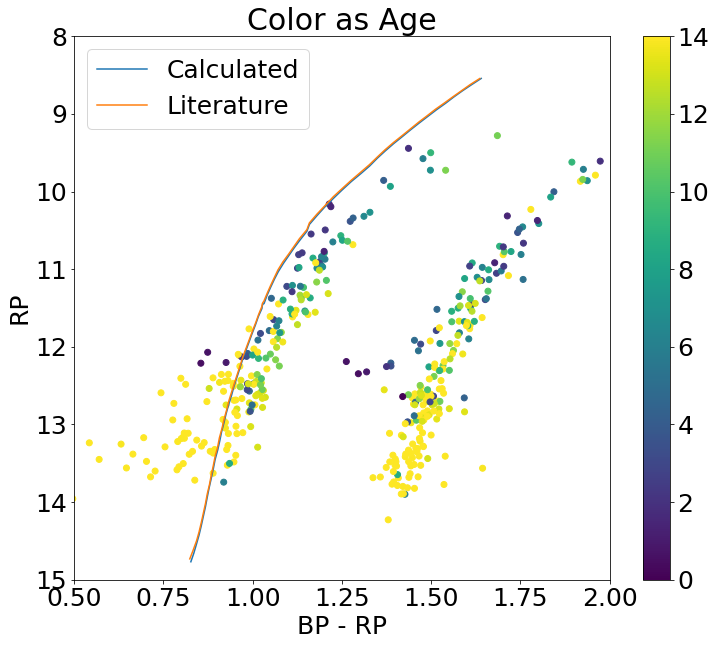

In [103]:
plt.figure(figsize=[12,10])
# plt.subplot(121)
plt.plot((massive['G_BPmag']-massive['G_RPmag'])[calc_iso][calc_sort],
         massive['G_RPmag'][calc_iso][calc_sort]+5.0*np.log10(3200)-5.0,label='Calculated')
plt.plot((massive['G_BPmag']-massive['G_RPmag'])[lite_iso][lite_sort],
         massive['G_RPmag'][lite_iso][lite_sort]+5.0*np.log10(3200.)-5.0,label='Literature')

plt.legend()

plt.scatter(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ebprp_ak*bf_params[:,1],
            gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-bf_params[:,1],c=bf_params[:,0],
            vmax=14,vmin=0)
plt.scatter(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'],
            gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'],c=bf_params[:,0],vmax=14,vmin=0)
plt.colorbar()

plt.xlim(0.5,2.0)
plt.ylim(8,15)
plt.gca().invert_yaxis()

plt.xlabel(r'BP - RP')
plt.ylabel(r'RP')
plt.title(r'Color as Age')

# plt.savefig('../plots/M22GaiaCMD.png',bbox_inches='tight',dpi=300)
plt.show()

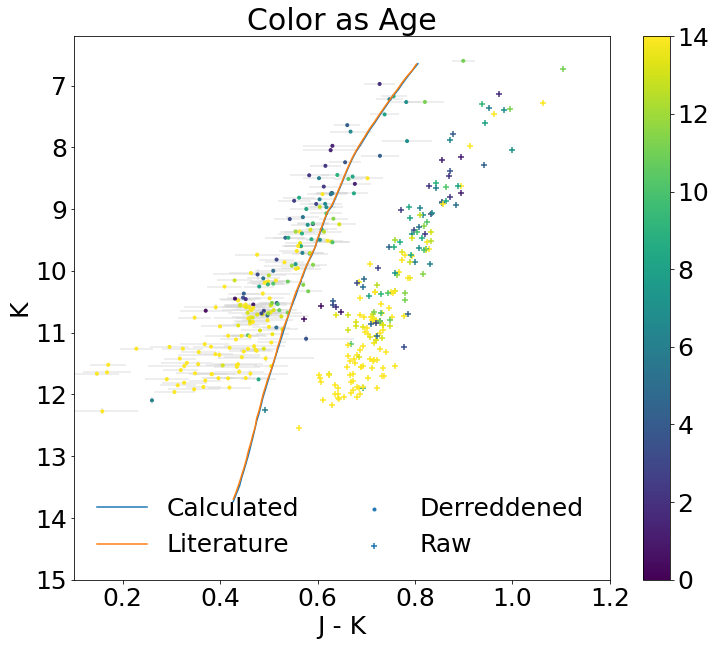

In [154]:
jk_err = np.sqrt(gcsdr17['J_ERR']**2+gcsdr17['K_ERR']**2+(ejk_ak*bf_params_err[:,1])**2)
k_err = np.sqrt(gcsdr17['K_ERR']**2+bf_params_err[:,1]**2)

plt.figure(figsize=[12,10])
# plt.subplot(121)
plt.plot((massive['Jmag']-massive['Ksmag'])[calc_iso][calc_sort],
         massive['Ksmag'][calc_iso][calc_sort]+5.0*np.log10(3200)-5.0,label='Calculated')
plt.plot((massive['Jmag']-massive['Ksmag'])[lite_iso][lite_sort],
         massive['Ksmag'][lite_iso][lite_sort]+5.0*np.log10(3200.)-5.0,label='Literature')

plt.legend()

plt.scatter(gcsdr17['J']-gcsdr17['K']-ejk_ak*bf_params[:,1],gcsdr17['K']-bf_params[:,1],c=bf_params[:,0],
            vmax=14,vmin=0,label='Derreddened',zorder=2,marker='.')
plt.scatter(gcsdr17['J']-gcsdr17['K'],gcsdr17['k'],c=bf_params[:,0],vmax=14,vmin=0,marker='+',
            label='Raw',zorder=0)
plt.colorbar()

plt.errorbar(gcsdr17['J']-gcsdr17['K']-ejk_ak*bf_params[:,1],gcsdr17['K']-bf_params[:,1],xerr=jk_err,
             yerr=k_err,c='lightgrey',ls=' ',zorder=1,alpha=0.5)

plt.legend(ncol=2,frameon=False)

plt.xlim(0.1,1.2)
plt.ylim(6.2,15)
plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Color as Age')

# plt.savefig('../plots/M22_2MASSCMD.png',bbox_inches='tight',dpi=300)
plt.show()